<a href="https://colab.research.google.com/github/IsaacGordin/MohonkForestData/blob/main/MohonkForestDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

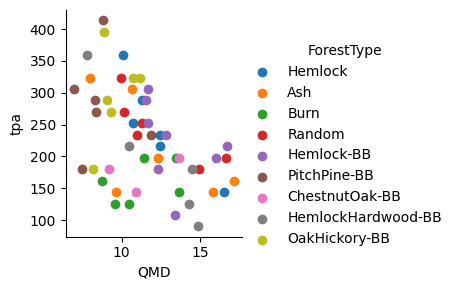

In [6]:
#Most Current Code Block!

#Code Block which contains functions to display the inaccuracies, compare 2018 & 2022 plots, display 21/22 plots, and more.?

#Import libraries
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from collections import defaultdict
import statistics
import seaborn

url = 'https://raw.githubusercontent.com/IsaacGordin/MohonkForestData/main/TreeDat.csv'
treedat = pd.read_csv(url)
fc = math.pi/(4*144) # value is used to convert diameter(inches) to area(feet), Forester's Constant
plotAreaSquareMeters = 225 #Value given to me by Megan Napoli, 15x15 meter plots
plotAreaAcres = plotAreaSquareMeters/4047

#This function will add: dbh in inches, basal area in square feet, and expansion factor to the dataframe
#The expansion factor is used to create a trees per acre value. The plots are ~ 1/18 acres, so one tree per plot represents 18 trees per acre
def colAdd(df):
  df['DBHInches'] = df['DBH']/2.54
  df['ba'] = (df['DBHInches']**2)*fc
  df['ef'] = 1/plotAreaAcres
  return df
treedat = colAdd(treedat)

#This function returns a dataframe of data by plot. The data includes the DBH/ba sum and avg, tree count, and forest type, and trees per acre.
def plotAverages(df, year):
  if(year == 2018):
    df = df[df['Year'] == 2018]
  else:
    df = df[df['Year'] > 2018]
  plotCount = df['Plot'].nunique()
  plotList = list(range(1,plotCount+1)) #Create empty lists to populate with data
  treeCount = [0]*plotCount
  DBHSum = [0]*plotCount
  QMD = [0]*plotCount
  baSum = [0]*plotCount
  DBHAvg = [0]*plotCount
  baAvg = [0]*plotCount
  baa = [0]*plotCount
  tpa = [0]*plotCount
  forestType = ['']*plotCount
  for index, row in df.iterrows(): #Iterate over dataset
    if(math.isnan(row['DBH']) | math.isnan(row['Tree_#'])): #Check that the tree is there
      continue
    DBHSum[row['Plot']-1] += row['DBHInches'] #Increment values
    baSum[row['Plot']-1] += row['ba']
    treeCount[row['Plot']-1] += 1
    forestType[row['Plot']-1] = row['Plot.Type']
  for i in plotList:
    DBHAvg[i-1] = DBHSum[i-1]/treeCount[i-1] #Average values
    baAvg[i-1] = baSum[i-1]/treeCount[i-1]
    QMD[i-1] = math.sqrt(baAvg[i-1]/fc)
    baa[i-1] = baSum[i-1] * (1/plotAreaAcres)
    tpa[i-1] = treeCount[i-1] * (1/plotAreaAcres)

  returnTable = pd.DataFrame({'Plot': plotList, 'TreeCount': treeCount, 'DBHSum': DBHSum, 'DBHAvg': DBHAvg, 'QMD': QMD,
                              'baSum': baSum, 'baAvg': baAvg,  'baa': baa, 'tpa': tpa, 'ForestType': forestType})
  return returnTable

#This function will show the change in diameter sum from the plots that were established in 2018 and resampled in 2022
def plotDelta(dataFrame):
  plotCount = dataFrame[dataFrame['Year']==2018]['Plot'].nunique()#Count of plots sampled in 2018
  dat2018 = plotAverages(dataFrame, 2018)
  dat2022 = plotAverages(dataFrame, 2020)
  dat2022 = dat2022[dat2022['Plot'] <= plotCount]
  deltaArr = [0]*plotCount
  for i in range(len(dat2018['DBHSum'])):
    deltaArr[i] = dat2022['DBHSum'][i] - dat2018['DBHSum'][i]
  return deltaArr

#This method creates a new data frame of trees that were sampled in 2018 and 2022 where the diameters are valid and accurate
#The checks we do include, does tree exist, does diameter data exist for both years, if diameter decreases by a large amount, if tree is dead, discard.
def deltaValid(df):
  plotCount = df[df['Year']==2018]['Plot'].nunique()
  plot, treenum, dbh18List, dbh22List, deltaList, species18List, species22List, status18List, status22List, forestTypeList = [],[],[],[],[],[],[],[],[],[]
  for i in range(1,(plotCount+1),1): #I represents the plot number
    for j in range(1, (len(df[df['Plot'] == i])+1),1): #J represents the tree number
      row18 = df[(df['Plot'] == i) & (df['Tree_#'] == j) & (df['Year'] == 2018)] #Unique row val
      row22 = df[(df['Plot'] == i) & (df['Tree_#'] == j) & (df['Year'] == 2022)]
      if(row18.empty | row22.empty): #.empty checks if data exists for the tree coordinates. ie, tree added in 22 doesn't exist in 18
        continue
      dbh18 = row18['DBHInches']
      dbh22 = row22['DBHInches']
      species18 = row18['Species'].values[0] #gets rid of all the noise, ie, 577 White pine Name: Species, dtype: object --> White Pine
      species22 = row22['Species'].values[0]
      status18 = str(row18['Status'].values[0])
      status22 = str(row22['Status'].values[0])
      forestType = row18['Plot.Type'].values[0]
      if(status18.__contains__('D') | status22.__contains__('D')): #This catches for if the tree is dead. Can't measure growth if tree died
        continue
      if(math.isnan(dbh18) | math.isnan(dbh22)):
        continue
      dbh18 = float(dbh18) # see .values[0], same purpose
      dbh22 = float(dbh22)
      decreasePercentage = .9
      delta = dbh22 - dbh18
      if((decreasePercentage*dbh18) > dbh22): #If the diameter decreased and it decreased by more than 10% of original diameter
        continue
      plot.append(i), treenum.append(j), dbh18List.append(dbh18), dbh22List.append(dbh22), deltaList.append(delta), species18List.append(species18)
      species22List.append(species22), status18List.append(status18), status22List.append(status22), forestTypeList.append(forestType)
  cleanedDat = pd.DataFrame({'Plot': plot, 'TreeNum': treenum, 'DBH18': dbh18List, 'DBH22': dbh22List, 'DeltaDBH': deltaList,
                'Species': species18List, 'Species22': species22List, 'Status18': status18List, 'Status22': status22List, 'ForestType': forestTypeList})
  return cleanedDat

#This function returns a dataframe of clean data from 21/22. Clean data is considered to have a non na number for plot, treenum, and DBH
def cleanModernDataTable(df):
  df = df[df['Year'] > 2018]
  plot, treenum, dbhList, baList, efList, speciesList, statusList, forestTypeList = [],[],[],[],[],[],[],[]
  for index, row in df.iterrows():
    if((math.isnan(row['Plot'])) | (math.isnan(row['Tree_#'])) | (math.isnan(row['DBH']))):
      continue
    plot.append(row['Plot'])
    treenum.append(row['Tree_#'])
    dbhList.append(row['DBHInches'])
    baList.append(row['ba'])
    efList.append(row['ef'])
    speciesList.append(row['Species'])
    statusList.append(row['Status'])
    forestTypeList.append(row['Plot.Type'])
    returnTable = pd.DataFrame({'Plot': plot, 'TreeNum': treenum, 'DBHInches': dbhList, 'ba': baList, 'ef': efList,
                'Species': speciesList, 'Status': statusList,'ForestType': forestTypeList})
  return returnTable

#This function will take a cleaned dataset and show measurement by type.
def plotter(df, xAxis, xAction, yAxis):
  dataList = list(set(df[yAxis])) #Set of the yAxis parameters become the keys
  SumDict = dict.fromkeys(dataList,0) #The 0 initializes the list at 0
  CountDict = dict.fromkeys(dataList,0)
  AvgDict = dict.fromkeys(dataList,0)
  for index, row in df.iterrows():
    yVal = row[yAxis] #The will represent the individual value of the ie, species
    xSum = float(row[xAxis])
    SumDict[yVal] += xSum #Increment the DBH sum,
    CountDict[yVal] += 1 #Increment the count

  for key in SumDict: #Create the averages
    AvgDict[key] = SumDict[key] / CountDict[key]

  cd = defaultdict(list) #This combines the lists
  for d in (SumDict, CountDict, AvgDict):
    for key, value in d.items():
      cd[key].append(value)

  values = [elem[xAction] for elem in cd.values()] #The xAxis parameter is used here to determine sum, count, or average

  fig, ax = plt.subplots()
  y_pos = np.arange(len(cd.keys()))
  ax.barh(y_pos, values, align='center')
  ax.set_yticks(y_pos, labels=cd.keys())
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel(xAxis)
  ax.set_title('')


modDat = cleanModernDataTable(treedat)
changeDat = deltaValid(treedat)
#plotter(changeDat, 'DeltaDBH', 0, 'Plot')
hemlock = modDat[(modDat['ForestType'] == 'Hemlock') | (modDat['ForestType'] == 'Hemlock-BB') | (modDat['ForestType'] == 'HemlockHardwood-BB')]
ash = modDat[modDat['ForestType'] == 'Ash']
burn = modDat[modDat['ForestType'] == 'Burn']
pp = modDat[modDat['ForestType'] == 'PitchPine-BB']
chest = modDat[(modDat['ForestType'] == 'ChestnutOak-BB') | (modDat['ForestType'] == 'Burn')]
oakhick = modDat[modDat['ForestType'] == 'OakHickory-BB']
#display(hemlock)
#plotter(chest, 'ba', 0, 'Species')
#plotter(oakhick, 'DBHInches', 2, 'Species')
#plotter(plotAverages(treedat, 2019), 'QMD', 2, 'ForestType')

#display(modDat)
dataList = list(set(modDat['Plot'])) #Set of the yAxis parameters become the keys
baSum = dict.fromkeys(dataList,0)
baCount = dict.fromkeys(dataList,0)
QMDDict = dict.fromkeys(dataList,0)
tpaSum = dict.fromkeys(dataList,0)
tpaCount = dict.fromkeys(dataList,0)
tpaDict = dict.fromkeys(dataList,0)
ForestTypeDict = dict.fromkeys(dataList,0)
for index, row in modDat.iterrows():
  plotNum = row['Plot'] #The will represent the individual value of the ie, species
  baSum[plotNum] += row['ba']
  baCount[plotNum] += 1
  tpaDict[plotNum] += row['ef']
  ForestTypeDict[plotNum] = row['ForestType']

for key in QMDDict: #Create the averages
  QMDDict[key] = math.sqrt((baSum[key] / baCount[key])/fc)

data2 = [QMDDict, tpaDict]
#d2 = pd.DataFrame(data = {'Plot': QMDDict.keys(), 'QMD': QMDDict.values(), 'tpa': tpaDict.values(), 'ForestType': ForestTypeDict.values()})
#display(d2)

#display(data)
dfx = pd.DataFrame.from_dict(data2).transpose()
dfx.columns = ['QMD', 'tpa']
#display(dfx)
#dfx = pd.DataFrame([QMDDict, tpaDict])
#dfx = dfx.set_index('Species', inplace=True)
#fg = seaborn.FacetGrid(data=d2)#, hue = 'ForestType')
#fg.map(plt.scatter, 'QMD', 'tpa').add_legend()

#plotter(deltaValid(treedat), 'DeltaDBH', 0, 'Plot')
#display(deltaValid(treedat))


#plt.scatter(plotAverages(treedat,2019)['QMD'], plotAverages(treedat,2019)['tpa'])
fg = seaborn.FacetGrid(data=plotAverages(treedat,2019), hue='ForestType')
fg.map(plt.scatter, 'QMD', 'tpa').add_legend()


This text block will be a place to keep values that I calculated and graphs that look good. This will evolve.\
Average forest level values from 21/22 data. \
Plots Sampled: 52 \
Basal Area per Acre: 161.6 sq ft.\
Trees per Acre: 229.3 \
Quadratic Mean Diameter at Breast Height: 11.5 inches \
Arithmetic Mean Diameter at Breast Height: 10.3 inches \
Average forest level values from 2018 data. \
Plots Sampled: 24 \
Basal Area per Acre: 175.4 sq ft.\
Trees per Acre: 226.3 \
Quadratic Mean Diameter at Breast Height: 12.0 inches \
Arithmetic Mean Diameter at Breast Height: 10.8 inches \
Below displays a scatter plot where the x axis is QMD and the y axis is tree per acre: \
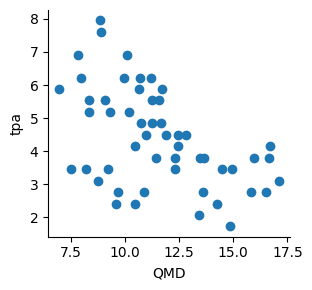


In [ ]:
#Helper Function
def dataCleaner(df):#This function will create a list of plot and tree numbers where there are inaccuracies
#We define inaccuracies as a change in species name or decrease in tree diameter
#We only need to compare the plots sampled in 2018 and 2022
  plotNumbers = []
  treeNumbers = []
  reason = []
  df = df[(df['Year']==2018) | (df['Year'] == 2022)]
  plotCount = df[df['Year']==2018]['Plot'].nunique()#Count of plots sampled in 2018
  for i in range(1,(plotCount+1),1):
    for j in range(1, (len(df[(df['Plot'] == i) & (df['Year'] == 2018)])+1),1):
      #Get index of Plot = i, TreeNum = j, Year = 2018/2022, first check if exists
      if(df[(df['Year'] == 2018) & (df['Plot'] == i) & (df['Tree_#'] == j)].empty |
         df[(df['Year'] == 2022) & (df['Plot'] == i) & (df['Tree_#'] == j)].empty):
        plotNumbers.append(i)
        treeNumbers.append(j)
        reason.append('NA index')
        continue
      index2018 = df.index[(df['Plot']==i) & (df['Tree_#']==j) & (df['Year']==2018)][0]
      index2022 = df.index[(df['Plot']==i) & (df['Tree_#']==j) & (df['Year']==2022)][0]
      #Complete a series of checks
      if(math.isnan(df['DBH'][index2018]) | math.isnan(df['DBH'][index2022])):
          plotNumbers.append(i)
          treeNumbers.append(j)
          reason.append('NA DBH')
          continue
      if(df['DBH'][index2018] > df['DBH'][index2022]):
        plotNumbers.append(i)
        treeNumbers.append(j)
        reason.append('Tree Shrank')
        continue
      #Create some catch for a large increase
      if(pd.isnull(df['Species'][index2018]) | pd.isnull(df['Species'][index2022])):
        plotNumbers.append(i)
        treeNumbers.append(j)
        reason.append('NA species')
        continue
      if(df['Species'][index2018] != df['Species'][index2022]):
        plotNumbers.append(i)
        treeNumbers.append(j)
        reason.append('Different Species')
        continue
  coordinates = pd.DataFrame({'Plot#': plotNumbers, 'Tree#': treeNumbers, 'Reason': reason})
  return coordinates

In [9]:
#Code block for change over time forest data analysis. There will be some overlap, but, oh well

#This python script will be to clean the data and analyze forest data from Mohonk Preserve

#Final end product goal: https://www.uvm.edu/femc/nefin/datavisualize, something like this

#Import libraries
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from collections import defaultdict

url = 'https://raw.githubusercontent.com/IsaacGordin/MohonkForestData/main/TreeDat.csv'
treedat = pd.read_csv(url)
fc = math.pi/(4*144) # value is used to convert diameter(inches) to area(feet), Forester's Constant
plotAreaSquareMeters = 225 #Value given to me by Megan Napoli, 15x15 meter plots
plotAreaAcres = plotAreaSquareMeters/4047


#This function will add: dbh in inches, basal area in square feet, and expansion factor to the dataframe
#The expansion factor is used to create a trees per acre value. The plots are ~ 1/18 acres, so one tree per plot represents 18 trees per acre
def colAdd(df):
  df['DBHInches'] = df['DBH']/2.54
  df['ba'] = (df['DBHInches']**2)*fc
  df['ef'] = 1/plotAreaAcres
  return df

treedat = colAdd(treedat)

#This function returns a dataframe of data by plot. The data includes the DBH/ba sum and avg, tree count, and forest type, and trees per acre
def plotAverages(df, year):
  if(year == 2018):
    df = df[df['Year'] == 2018]
  else:
    df = df[df['Year'] > 2018]
  plotCount = df['Plot'].nunique()
  plotList = list(range(1,plotCount+1)) #Create empty lists to populate with data
  treeCount = [0]*plotCount
  DBHSum = [0]*plotCount
  baSum = [0]*plotCount
  DBHAvg = [0]*plotCount
  baAvg = [0]*plotCount
  tpa = [0]*plotCount
  forestType = ['']*plotCount
  for index, row in df.iterrows(): #Iterate over dataset
    if(math.isnan(row['DBH']) | math.isnan(row['Tree_#'])): #Check that the tree is there
      continue
    DBHSum[row['Plot']-1] += row['DBH'] #Increment values
    baSum[row['Plot']-1] += row['ba']
    treeCount[row['Plot']-1] += 1
    forestType[row['Plot']-1] = row['Plot.Type']
    tpa[row['Plot']-1] += row['ef']

  for i in plotList:
    DBHAvg[i-1] = DBHSum[i-1]/treeCount[i-1] #Average values
    baAvg[i-1] = baSum[i-1]/treeCount[i-1]

  returnTable = pd.DataFrame({'Plot': plotList, 'DBHSum': DBHSum, 'baSum': baSum, 'TreeCount': treeCount,
                              'DBHAvg': DBHAvg, 'baAvg': baAvg, 'tpa': tpa, 'ForestType': forestType})
  return returnTable


def dataCleaner(dataFrame):#This function will create a list of plot and tree numbers where there are inaccuracies
#We define inaccuracies as a change in species name or decrease in tree diameter
#We only need to compare the plots sampled in 2018 and 2022
  plotNumbers = []
  treeNumbers = []
  reason = []
  plotCount = dataFrame[dataFrame['Year']==2018]['Plot'].nunique()#Count of plots sampled in 2018
  for i in range(1,(plotCount+1),1):
    for j in range(1, (len(dataFrame[(dataFrame['Plot'] == i) & (dataFrame['Year'] == 2018)])+1),1):
      #Get index of Plot = i, TreeNum = j, Year = 2018/2022, first check if exists
      if(dataFrame[(dataFrame['Year'] == 2018) & (dataFrame['Plot'] == i) & (dataFrame['Tree_#'] == j)].empty |
         dataFrame[(dataFrame['Year'] == 2022) & (dataFrame['Plot'] == i) & (dataFrame['Tree_#'] == j)].empty):
        plotNumbers.append(i)
        treeNumbers.append(j)
        reason.append('NA index')
        print('NA index at Plot:', i, 'Tree:', j)
        continue
      index2018 = dataFrame.index[(dataFrame['Plot']==i) & (dataFrame['Tree_#']==j) & (dataFrame['Year']==2018)][0]
      index2022 = dataFrame.index[(dataFrame['Plot']==i) & (dataFrame['Tree_#']==j) & (dataFrame['Year']==2022)][0]
      #Complete a series of checks
      if(math.isnan(dataFrame['DBH'][index2018]) | math.isnan(dataFrame['DBH'][index2022])):
          plotNumbers.append(i)
          treeNumbers.append(j)
          reason.append('NA DBH')
          print('NA DBH at Plot:', i, 'Tree:', j)
          continue
      if(pd.isnull(dataFrame['Species'][index2018]) | pd.isnull(dataFrame['Species'][index2022])):
        plotNumbers.append(i)
        treeNumbers.append(j)
        reason.append('NA species')
        print('NA Species at Plot:', i, 'Tree:', j)
        continue
      if(dataFrame['DBH'][index2018] > dataFrame['DBH'][index2022]):
        plotNumbers.append(i)
        treeNumbers.append(j)
        reason.append('Tree Shrank')
        print('Tree shrank at Plot:', i, 'Tree:', j)
        print('2018 DBH:', dataFrame['DBH'][index2018], '2022 DBH:', dataFrame['DBH'][index2022])
      #Create some catch for a large increase
      if(dataFrame['Species'][index2018] != dataFrame['Species'][index2022]):
        plotNumbers.append(i)
        treeNumbers.append(j)
        reason.append('Different Species')
        print('Different Species at Plot:', i, 'Tree:', j)
        print('2018 Species:', dataFrame['Species'][index2018], '2022 Species:', dataFrame['Species'][index2022])
  coordinates = {'Plot#': plotNumbers, 'Tree#': treeNumbers, 'Reason': reason}
  return coordinates


inaccuracies = pd.DataFrame(dataCleaner(treedat))
#display(pd.DataFrame(inaccuracies))
inaccuracies.to_csv('inaccuracies.csv')


#This function will show the change in diameter sum from the plots that were established in 2018 and resampled in 2022
def plotDelta(dataFrame):
  plotCount = dataFrame[dataFrame['Year']==2018]['Plot'].nunique()#Count of plots sampled in 2018
  dat2018 = plotAverages(dataFrame, 2018)
  dat2022 = plotAverages(dataFrame, 2020)
  dat2022 = dat2022[dat2022['Plot'] <= plotCount]
  deltaArr = [0]*plotCount
  for i in range(len(dat2018['DBHSum'])):
    deltaArr[i] = dat2022['DBHSum'][i] - dat2018['DBHSum'][i]
  return deltaArr

#This method creates a new data frame of trees that were sampled in 2018 and 2022 where the diameters are valid and accurate
#The checks we do include, does tree exist, does diameter data exist for both years, if diameter decreases by a large amount, if tree is dead, discard.
def deltaValid(dataFrame):
  plotCount = dataFrame[dataFrame['Year']==2018]['Plot'].nunique()#Plot count for 2018 and 2022
  col = ['Plot', 'Tree', 'DBH18', 'DBH22', 'DeltaDBH', 'Species18', 'Species22', 'Status18', 'Status22', 'ForestType'] #Column Array for the return function
  cleanedDat = pd.DataFrame(columns = col) #DataFrame that we will return
  for i in range(1,(plotCount+1),1): #I represents the plot number
    for j in range(1, (len(dataFrame[dataFrame['Plot'] == i])+1),1): #J represents the tree number
      row18 = dataFrame[(dataFrame['Plot'] == i) & (dataFrame['Tree_#'] == j) & (dataFrame['Year'] == 2018)] #Unique row val
      row22 = dataFrame[(dataFrame['Plot'] == i) & (dataFrame['Tree_#'] == j) & (dataFrame['Year'] == 2022)]
      if(row18.empty | row22.empty): #.empty checks if data exists for the tree coordinates. ie, tree added in 22 doesn't exist in 18
        continue
      dbh18 = row18['DBH']
      dbh22 = row22['DBH']
      species18 = row18['Species'].values[0] #gets rid of all the noise, ie, 577 White pine Name: Species, dtype: object --> White Pine
      species22 = row22['Species'].values[0]
      status18 = str(row18['Status'].values[0])
      status22 = str(row22['Status'].values[0])
      forestType = row18['Plot.Type'].values[0]
      if(status18.__contains__('D') | status22.__contains__('D')): #This catches for if the tree is dead. Can't measure growth if tree died
        continue
      if(math.isnan(dbh18) | math.isnan(dbh22)):
        continue
      dbh18 = float(dbh18) # see .values[0], same purpose
      dbh22 = float(dbh22)
      decreasePercentage = .9
      delta = dbh22 - dbh18
      if((decreasePercentage*dbh18) > dbh22): #If the diameter decreased and it decreased by more than 10% of original diameter
        continue
      cleanedDat.loc[len(cleanedDat.index)] = [i, j, dbh18, dbh22, delta, species18, species22, status18, status22, forestType]#add data if passes all checks
  return cleanedDat

def deltaValid2(df):
  plotCount = df[df['Year']==2018]['Plot'].nunique()
  plot, treenum, dbh18List, dbh22List, deltaList, species18List, species22List, status18List, status22List, forestTypeList = [],[],[],[],[],[],[],[],[],[]
  for i in range(1,(plotCount+1),1): #I represents the plot number
    for j in range(1, (len(df[df['Plot'] == i])+1),1): #J represents the tree number
      row18 = df[(df['Plot'] == i) & (df['Tree_#'] == j) & (df['Year'] == 2018)] #Unique row val
      row22 = df[(df['Plot'] == i) & (df['Tree_#'] == j) & (df['Year'] == 2022)]
      if(row18.empty | row22.empty): #.empty checks if data exists for the tree coordinates. ie, tree added in 22 doesn't exist in 18
        continue
      dbh18 = row18['DBH']
      dbh22 = row22['DBH']
      species18 = row18['Species'].values[0] #gets rid of all the noise, ie, 577 White pine Name: Species, dtype: object --> White Pine
      species22 = row22['Species'].values[0]
      status18 = str(row18['Status'].values[0])
      status22 = str(row22['Status'].values[0])
      forestType = row18['Plot.Type'].values[0]
      if(status18.__contains__('D') | status22.__contains__('D')): #This catches for if the tree is dead. Can't measure growth if tree died
        continue
      if(math.isnan(dbh18) | math.isnan(dbh22)):
        continue
      dbh18 = float(dbh18) # see .values[0], same purpose
      dbh22 = float(dbh22)
      decreasePercentage = .9
      delta = dbh22 - dbh18
      if((decreasePercentage*dbh18) > dbh22): #If the diameter decreased and it decreased by more than 10% of original diameter
        continue
      plot.append(i), treenum.append(j), dbh18List.append(dbh18), dbh22List.append(dbh22), deltaList.append(delta), species18List.append(species18)
      species22List.append(species22), status18List.append(status18), status22List.append(status22), forestTypeList.append(forestType)
  cleanedDat = pd.DataFrame({'Plot': plot, 'TreeNum': treenum, 'DBH18': dbh18List, 'DBH22': dbh22List, 'DeltaDBH': deltaList,
                'Species': species18List, 'Species22': species22List, 'Status18': status18List, 'Status22': status22List, 'ForestType': forestTypeList})
  return cleanedDat

#display(deltaValid2(treedat))


def modernDataTable(df):
  col = ['Plot', 'Tree', 'DBH', 'Species', 'Status', 'ForestType'] #Column Array for the return function
  returnTable = pd.DataFrame(columns = col)
  for index, row in df.iterrows():
    if(row['Year'] == 2018):
      continue
    if((math.isnan(row['Plot'])) | (math.isnan(row['Tree_#'])) | (math.isnan(row['DBH']))):
      continue
    plot = row['Plot']
    tree = row['Tree_#']
    dbh = row['DBH']
    species = row['Species'] #gets rid of all the noise, ie, 577 White pine Name: Species, dtype: object --> White Pine
    status = row['Status']
    forestType = row['Plot.Type']
    dbh = float(dbh)
    returnTable.loc[len(returnTable.index)] = [plot, tree, dbh, species, status, forestType]#add data if passes all checks
  return returnTable

#Let's try to create a plot from inputs. Parameters: DataFrame, x axis(sum, count, avg), y axis(Species18, Plot, ForestType)
#xAxis == 0, returns the sum, 1 -> count, 2 -> average
#yAxis, Species18, Species22, Plot, ForestType
#If I want to specify a certain type of forest type or plot# in the
def plotter(df, xAxis, yAxis):
  #First, clean the data set
  cleanDataSet = deltaValid(df)
  #cleanDataSet = cleanDataSet[cleanDataSet['Plot']==1]

  dataList = list(set(cleanDataSet[yAxis])) #Set of the yAxis parameters become the keys
  SumDict = dict.fromkeys(dataList,0) #The 0 initializes the list at 0
  CountDict = dict.fromkeys(dataList,0)
  AvgDict = dict.fromkeys(dataList,0)
  for index, row in cleanDataSet.iterrows():
    yVal = row[yAxis] #The will represent the individual value of the ie, species
    delta = float(row['DeltaDBH'])
    SumDict[yVal] += delta #Increment the DBH sum,
    CountDict[yVal] += 1 #Increment the count

  for key in SumDict: #Create the averages
    AvgDict[key] = SumDict[key] / CountDict[key]

  cd = defaultdict(list) #This combines the lists
  for d in (SumDict, CountDict, AvgDict):
    for key, value in d.items():
      cd[key].append(value)

  values = [elem[xAxis] for elem in cd.values()] #The xAxis parameter is used here to determine sum, count, or average

  fig, ax = plt.subplots()
  y_pos = np.arange(len(cd.keys()))
  ax.barh(y_pos, values, align='center')
  ax.set_yticks(y_pos, labels=cd.keys())
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel(xAxis)
  ax.set_title('')


output = modernDataTable(treedat)
#plotter(treedat, 0, 'Species18')
#display(output)


Tree shrank at Plot: 1 Tree: 1
2018 DBH: 31.9 2022 DBH: 31.8
Tree shrank at Plot: 1 Tree: 6
2018 DBH: 23.0 2022 DBH: 22.9
Tree shrank at Plot: 1 Tree: 7
2018 DBH: 20.7 2022 DBH: 20.4
Tree shrank at Plot: 1 Tree: 15
2018 DBH: 11.5 2022 DBH: 11.1
Tree shrank at Plot: 2 Tree: 2
2018 DBH: 19.7 2022 DBH: 19.5
Tree shrank at Plot: 2 Tree: 5
2018 DBH: 11.4 2022 DBH: 10.9
Tree shrank at Plot: 2 Tree: 6
2018 DBH: 12.6 2022 DBH: 12.2
Tree shrank at Plot: 2 Tree: 8
2018 DBH: 11.4 2022 DBH: 10.9
Tree shrank at Plot: 2 Tree: 9
2018 DBH: 11.8 2022 DBH: 11.7
NA DBH at Plot: 2 Tree: 12
Tree shrank at Plot: 2 Tree: 13
2018 DBH: 24.5 2022 DBH: 24.4
Tree shrank at Plot: 2 Tree: 14
2018 DBH: 11.3 2022 DBH: 10.6
Tree shrank at Plot: 2 Tree: 15
2018 DBH: 12.0 2022 DBH: 10.7
NA DBH at Plot: 2 Tree: 17
Different Species at Plot: 3 Tree: 2
2018 Species: Red oak 2022 Species: Black oak
Tree shrank at Plot: 3 Tree: 5
2018 DBH: 41.8 2022 DBH: 39.2
Tree shrank at Plot: 3 Tree: 7
2018 DBH: 35.9 2022 DBH: 35.7
NA DB

,Plot,TreeNum,DBHInches,ba,ef,Species,Status18,ForestType
0,1,1.0,12.519685,0.854898,17.986667,Eastern hemlock,AS,Hemlock
1,1,2.0,12.519685,0.854898,17.986667,Pignut hickory,AS,Hemlock
2,1,3.0,10.314961,0.580313,17.986667,Tulip poplar,AS,Hemlock
3,1,4.0,4.921260,0.132093,17.986667,Sugar maple,AS,Hemlock
4,1,5.0,16.614173,1.505514,17.986667,Eastern hemlock,DS,Hemlock
...,...,...,...,...,...,...,...,...
658,52,6.0,4.960630,0.134215,17.986667,Hop hornbeam,AS,OakHickory-BB
659,52,7.0,6.811024,0.253018,17.986667,Sugar maple,AS,OakHickory-BB
660,52,8.0,7.283465,0.289337,17.986667,White ash,DL,OakHickory-BB
661,52,9.0,5.669291,0.175301,17.986667,Red maple,AS,OakHickory-BB


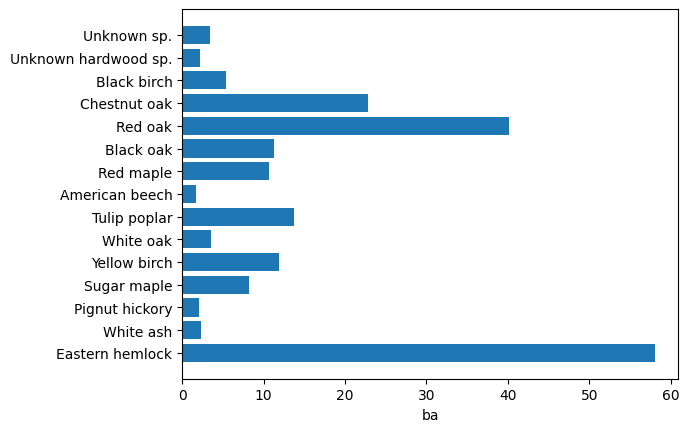

In [ ]:
#Code block for current forest data analysis

#This python script will be to clean the data and analyze forest data from Mohonk Preserve

#Final end product goal: https://www.uvm.edu/femc/nefin/datavisualize, something like this

#Import libraries
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from collections import defaultdict

url = 'https://raw.githubusercontent.com/IsaacGordin/MohonkForestData/main/TreeDat.csv'
treedat = pd.read_csv(url)
fc = math.pi/(4*144) # value is used to convert diameter(inches) to area(feet), Forester's Constant
plotAreaSquareMeters = 225 #Value given to me by Megan Napoli, 15x15 meter plots
plotAreaAcres = plotAreaSquareMeters/4047

#This function will add: dbh in inches, basal area in square feet, and expansion factor to the dataframe
#The expansion factor is used to create a trees per acre value. The plots are ~ 1/18 acres, so one tree per plot represents 18 trees per acre
def colAdd(df):
  df['DBHInches'] = df['DBH']/2.54
  df['ba'] = (df['DBHInches']**2)*fc
  df['ef'] = 1/plotAreaAcres
  return df

treedat = colAdd(treedat)

#This function returns a dataframe of data by plot. The data includes the DBH/ba sum and avg, tree count, and forest type, and trees per acre
def modernPlotAverages(df):
  df = df[df['Year'] > 2018] #We only want current data
  plotCount = df['Plot'].nunique()
  plotList = list(range(1,plotCount+1)) #Create empty lists to populate with data
  treeCount = [0]*plotCount
  DBHSum = [0]*plotCount
  baSum = [0]*plotCount
  DBHAvg = [0]*plotCount
  baAvg = [0]*plotCount
  tpa = [0]*plotCount
  forestType = ['']*plotCount
  for index, row in df.iterrows(): #Iterate over dataset
    if(math.isnan(row['DBH']) | math.isnan(row['Tree_#'])): #Check that the tree is there
      continue
    DBHSum[row['Plot']-1] += row['DBH'] #Increment values
    baSum[row['Plot']-1] += row['ba']
    treeCount[row['Plot']-1] += 1
    forestType[row['Plot']-1] = row['Plot.Type']
    tpa[row['Plot']-1] += row['ef']

  for i in plotList:
    DBHAvg[i-1] = DBHSum[i-1]/treeCount[i-1]
    baAvg[i-1] = baSum[i-1]/treeCount[i-1]

  returnTable = pd.DataFrame({'Plots': plotList, 'DBHSum': DBHSum, 'baSum': baSum, 'TreeCount': treeCount,
                              'DBHAvg': DBHAvg, 'baAvg': baAvg, 'tpa': tpa, 'ForestType': forestType})
  return returnTable

#This function returns a dataframe of clean data from 21/22
def cleanModernDataTable(df):
  df = df[df['Year'] > 2018]
  plot, treenum, dbhList, baList, efList, speciesList, statusList, forestTypeList = [],[],[],[],[],[],[],[]
  for index, row in df.iterrows():
    if((math.isnan(row['Plot'])) | (math.isnan(row['Tree_#'])) | (math.isnan(row['DBH']))):
      continue
    plot.append(row['Plot'])
    treenum.append(row['Tree_#'])
    dbhList.append(row['DBHInches'])
    baList.append(row['ba'])
    efList.append(row['ef'])
    speciesList.append(row['Species'])
    statusList.append(row['Status'])
    forestTypeList.append(row['Plot.Type'])
    returnTable = pd.DataFrame({'Plot': plot, 'TreeNum': treenum, 'DBHInches': dbhList, 'ba': baList, 'ef': efList,
                'Species': speciesList, 'Status': statusList,'ForestType': forestTypeList})
  return returnTable
display(cleanModernDataTable(treedat))

#This function is to generalize the cleaned forest data into a simple bar graph.
#df is the dataFrame(treedat)
#xAxis is the value we will sum, count or average, DBH, ba, ef
#action is the statistic we will derive, sum, count, average, 0->sum, 1->count, 2->average
#yAxis is what the action is done over, plots, forest type, tree status, species
def plotter(df, xAxis, xAction, yAxis):
  #First, turn the data set into an easy to interpret table, of only modern data
  cleanDataSet = cleanModernDataTable(df)
  #cleanDataSet = cleanDataSet[cleanDataSet['ForestType']=='Hemlock']
  cleanDataSet = cleanDataSet[(cleanDataSet['ForestType']=='Hemlock') | (cleanDataSet['ForestType'] == 'HemlockHardwood-BB') | (cleanDataSet['ForestType'] == 'Hemlock-BB')]

  dataList = list(set(cleanDataSet[yAxis])) #Set of the yAxis parameters become the keys
  SumDict = dict.fromkeys(dataList,0) #The 0 initializes the list at 0
  CountDict = dict.fromkeys(dataList,0)
  AvgDict = dict.fromkeys(dataList,0)
  for index, row in cleanDataSet.iterrows():
    yVal = row[yAxis] #The will represent the individual value of the ie, species
    xSum = float(row[xAxis])
    SumDict[yVal] += xSum #Increment the DBH sum,
    CountDict[yVal] += 1 #Increment the count

  for key in SumDict: #Create the averages
    AvgDict[key] = SumDict[key] / CountDict[key]

  cd = defaultdict(list) #This combines the lists
  for d in (SumDict, CountDict, AvgDict):
    for key, value in d.items():
      cd[key].append(value)

  values = [elem[xAction] for elem in cd.values()] #The xAxis parameter is used here to determine sum, count, or average

  fig, ax = plt.subplots()
  y_pos = np.arange(len(cd.keys()))
  ax.barh(y_pos, values, align='center')
  ax.set_yticks(y_pos, labels=cd.keys())
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel(xAxis)
  ax.set_title('')


#display(cleanModernDataTable(treedat))
plotter(treedat, 'ba', 0, 'Species')




In [ ]:
'''

def plotAverages(dataFrame): #Creates a dictionary of values by plot from given dataset
    #Values are sum of diameter by plot, sum of ba by plot, tree count per plot, dbh avg per plot, ba avg per plot
    plotAreaSquareMeters = 225 #Value given to me by Megan Napoli, 15x15 meter plots
    plotAreaAcres = plotAreaSquareMeters/4047
    plotCount = dataFrame['Plot'].nunique()
    plot = [0]*plotCount
    treeCount = [0]*plotCount
    DBHSum = [0]*plotCount
    baSum = [0]*plotCount
    DBHAvg = [0]*plotCount
    baAvg = [0]*plotCount
    tpa = [0]*plotCount
    plotSize = 1/plotAreaAcres
    forestType = ['']*plotCount
    col = ['Plot', 'TreeCount', 'DBHSum', 'DBHAvg','baSum', 'baAvg', 'baCount', 'ef', 'ForestType']

    indexVal = 0
    #Double nested for loop. Will loop over the plots and individual tree data
    for i in range(1,(plotCount+1),1):
        for j in range(len(dataFrame[dataFrame['Plot']==i])):
            if(dataFrame['Year'][indexVal] == 2018): #We are only looking for 2021/2022 data
              #We are only looking for the most recent data
                indexVal+=1
                continue
            else:
                if(not(math.isnan(dataFrame['DBHInches'][indexVal]))):
                  #We do (i-1) because the plots are referenced at '1' and arrays are 0 referenced
                    DBHSum[i-1] += dataFrame['DBHInches'][indexVal] #DBHSum
                    baSum[i-1] += dataFrame['ba'][indexVal] #Basal Area Sum
                #QUESTION!: If the DBH is na, what should I do, still increment the tree count?
                #This will bring down the average diameter. To determine.
                treeCount[i-1] +=1
                indexVal+=1
    for i in range(plotCount):
        DBHAvg[i] = DBHSum[i]/treeCount[i]
        baAvg[i] = baSum[i]/treeCount[i]
        forestType[i] = dataFrame['Plot.Type'][dataFrame[dataFrame['Plot']==(i+1)].index[0]]
        plot[i] = (i+1)
        tpa[i] = plotSize * treeCount[i]

    returnTable = {'Plot': plot, 'DBHSum': DBHSum, 'baSum': baSum, 'TreeCount': treeCount, 'DBHAvg': DBHAvg, 'baAvg': baAvg, 'tpa': tpa, 'ForestType':  forestType}
    returnTableDF = pd.DataFrame.from_dict(returnTable, orient = 'index')
    returnTableDF = returnTableDF.transpose()
    return returnTableDF
#display(plotAverages(treedat))

'''

'''
def plotAverages2018(dataFrame):
  plotCount = dataFrame[dataFrame['Year']==2018]['Plot'].nunique()
  plotAvgs = np.zeros((plotCount, 5))
  DBHSum = [0]*plotCount
  baSum = [0]*plotCount
  treeCount = [0]*plotCount
  DBHAvg = [0]*plotCount
  baAvg = [0]*plotCount
  tpa = [0]*plotCount
  plot = [0]*plotCount
  forestType = ['']*plotCount
  plotAvgsReference = ['DBHSum', 'baSum', 'treeCount', 'DBHAvg', 'baAvg', 'ForestType']

  indexVal = 0
  for i in range(1,(plotCount+1),1):
      for j in range(len(dataFrame[dataFrame['Plot']==i])):
        if(dataFrame['Year'][indexVal] == 2022): #We are only looking for 2018 data
              #We are only looking for the most recent data
                indexVal+=1
                continue
        else:
          if(not(math.isnan(dataFrame['DBHInches'][indexVal]))):
            #We do (i-1) because the plots are referenced at '1' and arrays are 0 referenced
            DBHSum[i-1] += dataFrame['DBHInches'][indexVal] #DBHSum
            baSum[i-1] += dataFrame['ba'][indexVal] #Basal Area Sum
            treeCount[i-1] +=1
                #QUESTION!: If the DBH is na, what should I do, still increment the tree count?
                #This will bring down the average diameter. To determine.
            indexVal+=1

  for i in range(plotCount):
      DBHAvg[i] = DBHSum[i]/treeCount[i]
      baAvg[i] = baSum[i]/treeCount[i]
      forestType[i] = dataFrame['Plot.Type'][dataFrame[dataFrame['Plot']==(i+1)].index[0]]
      plot[i] = i+1
      tpa[i] = plotAreaAcres * (1/treeCount[i])

  returnTable = {'DBHSum': DBHSum, 'baSum': baSum, 'TreeCount': treeCount, 'DBHAvg': DBHAvg, 'baAvg': baAvg, 'ForestType':  forestType}
  returnTable = pd.DataFrame.from_dict(returnTable)
  return returnTable
'''




